In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt

import string
from os import listdir
import os
import errno
import subprocess
from collections import defaultdict
import operator
import re
import pickle
from collections import OrderedDict
import six # needed for Google Cloud client

import unidecode

import numpy as np
import pandas as pd
import scipy.sparse

from tqdm import tqdm, tqdm_pandas

from scipy.sparse.csr import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from sklearn.manifold import TSNE

import nltk

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
try:
    df = pd.read_json('ethnic_categories.json', dtype={})
except ValueError:
    df = pd.read_json(os.path.join('recipes', 'ethnic_categories.json'), dtype={})

In [4]:
print 'dataset size:', len(df)
df.sample(5)

dataset size: 14442


,categories,cookingTime,description,ethnicCategory,fullCategoryTree,ingredients,instructionSteps,name,rating,ratingCount,url
4259,"[Fish Recipes, Main Dish Halibut, Everyday Coo...",PT2H25M,NaN,us-recipes,us-recipes,"[1/2 cup fresh grapefruit juice, 1/4 cup olive...","[Mix together grapefruit juice, olive oil, 2 t...",Grilled Halibut I,4.14,6,http://allrecipes.com/recipe/12726/grilled-hal...
3648,"[Spicy Appetizers, Chicken Appetizers, Appetiz...",PT55M,NaN,us-recipes,us-recipes,"[24 chicken drumettes, 2 cups buttermilk, 4 cu...",[Place the chicken drumettes and buttermilk in...,Di's Buffalo Wings,4.11,13,http://allrecipes.com/recipe/31239/dis-buffalo...
4549,"[Onion Side Dishes, Vegetable Side Dishes, Sid...",NaN,NaN,us-recipes,us-recipes,"[4 large onions, peeled and halved, 2 tablespo...",[Preheat oven to 375 degrees F (190 degrees C)...,Sweet and Sour Onions,4.50,3,http://allrecipes.com/recipe/14075/sweet-and-s...
6430,"[Muffins, Quick Bread, Bread Recipes, Recipes,...",PT30M,NaN,us-recipes,us-recipes,"[1/2 cup butter, softened, 1/2 cup dark brown ...",[Preheat oven to 375 degrees F (190 degrees C)...,Oatmeal Maple Syrup Muffins,3.91,66,http://allrecipes.com/recipe/23520/oatmeal-map...
4976,"[Seafood Soup, Soup, Soups, Stews and Chili, C...",PT1H20M,NaN,us-recipes,us-recipes,"[1/4 pound salt pork, cubed, 1/2 cup finely ch...",[Cook and stir salt pork in a 5-quart Dutch ov...,Rhode Island Clam Chowder,3.00,1,http://allrecipes.com/recipe/241843/rhode-isla...


In [5]:
df[['url']].values[5883]

array([u'http://allrecipes.com/recipe/26671/texas-cowboy-chili-beans/'], dtype=object)

In [6]:
#df[['ethnicCategory']].values.nunique()
df['ethnicCategory'].value_counts()

us-recipes                      3504
italian                         2420
mexican                         2112
canadian                        1030
indian                           671
australian-and-new-zealander     499
french                           440
greek                            377
chinese                          323
german                           301
thai                             227
japanese                         222
irish                            199
filipino                         147
english                          143
spanish                          120
polish                           119
korean                           117
swedish                          102
brazilian                         93
russian                           84
cuban                             81
vietnamese                        66
puerto-rican                      66
portuguese                        66
lebanese                          61
moroccan                          53
s

In [7]:
cat_mapping_lines = """argentinian  latin_american
australian-and-new-zealander  north_european
austrian  north_european
bangladeshi  south_asian
belgian  north_european
brazilian  latin_american
canadian  north_american
chilean  latin_american
chinese  east_asian
colombian  latin_american
cuban  latin_american
czech  east_european
danish  north_european
dutch  north_european
east-african  african
egyptian  african
english  north_european
filipino  southeast_asian
finnish  north_european
french  north_european
german  north_european
greek  middle_eastern
hungarian  east_european
indian  south_asian
indonesian  southeast_asian
irish  north_european
israeli  middle_eastern
italian  south_european
jamaican  latin_american
japanese  east_asian
korean  east_asian
lebanese  middle_eastern
malaysian  southeast_asian
mexican  latin_american
moroccan  african
norwegian  north_european
pakistani  south_asian
persian  middle_eastern
peruvian  latin_american
polish  east_european
portuguese  south_european
puerto-rican  latin_american
russian  east_european
scottish  north_european
south-african  african
spanish  south_european
swedish  north_european
swiss  north_european
thai  southeast_asian
turkish  middle_eastern
us-recipes  north_american
vietnamese  southeast_asian
welsh  north_european"""

#print cat_mapping_lines
cat_mapping_dict = {}
cat_mapping_list = cat_mapping_lines.split('\n')
#print cat_mapping_list

for mapping in cat_mapping_list:
    #print line
    smaller_category, larger_category = mapping.split()
    cat_mapping_dict[smaller_category] = larger_category
print cat_mapping_dict

{'australian-and-new-zealander': 'north_european', 'portuguese': 'south_european', 'irish': 'north_european', 'mexican': 'latin_american', 'chinese': 'east_asian', 'czech': 'east_european', 'scottish': 'north_european', 'east-african': 'african', 'japanese': 'east_asian', 'moroccan': 'african', 'spanish': 'south_european', 'persian': 'middle_eastern', 'polish': 'east_european', 'austrian': 'north_european', 'swedish': 'north_european', 'israeli': 'middle_eastern', 'puerto-rican': 'latin_american', 'turkish': 'middle_eastern', 'south-african': 'african', 'bangladeshi': 'south_asian', 'german': 'north_european', 'peruvian': 'latin_american', 'indian': 'south_asian', 'dutch': 'north_european', 'korean': 'east_asian', 'pakistani': 'south_asian', 'colombian': 'latin_american', 'belgian': 'north_european', 'danish': 'north_european', 'indonesian': 'southeast_asian', 'hungarian': 'east_european', 'egyptian': 'african', 'welsh': 'north_european', 'brazilian': 'latin_american', 'us-recipes': 'n

In [8]:
def consolidate_ethnic_categories(cat):
    return cat_mapping_dict[cat]
df['consolidated_category'] = df['ethnicCategory'].apply(consolidate_ethnic_categories)

In [9]:
df.groupby('consolidated_category').consolidated_category.count()

consolidated_category
african             140
east_asian          662
east_european       267
latin_american     2517
middle_eastern      555
north_american     4534
north_european     1938
south_asian         714
south_european     2606
southeast_asian     509
Name: consolidated_category, dtype: int64

In [14]:
from cleaning_util import extract_ingredients, translate_non_alphanumerics

tqdm.pandas()

In [15]:
df['cleanedIngredients']=df['ingredients'].progress_map(extract_ingredients)


 38%|███▊      | 5443/14442 [00:08<00:13, 647.18it/s]

100%|██████████| 14442/14442 [00:21<00:00, 678.16it/s]

In [16]:
df[['cleanedIngredients','consolidated_category']].sample(5)

,cleanedIngredients,consolidated_category
2527,"[sour cream, ranchstyle salad dressing, picant...",latin_american
5212,"[cooking spray, elbow macaroni, cream chicken ...",north_american
7200,"[brown sugar, butter, dark rum, nutmeg, cinnamon]",north_american
6090,"[tomatovegetable juice cocktail, shrimp, cucum...",latin_american
11253,"[eggs, dijon mustard, lemon juice, extravirgin...",south_european


# EDA: Word to Vec Model 

Word to vec using gensim: https://radimrehurek.com/gensim/models/word2vec.html  
Here we are creating the word vectors from the list of clean ingredients. We use the Gensim model to create the similarity matrix(cosine similarity)


In [17]:
#!pip install gensim

from gensim.models.word2vec import Word2Vec

print('Training a Word2vec model...')
w2v_model = Word2Vec(df['cleanedIngredients'].values, size=100, window=5, min_count=5, workers=4)

Training a Word2vec model...


In [18]:
w2v_model.wv.most_similar(positive=['onion'])

[('chicken broth', 0.9786624908447266),
 ('onions', 0.9745464324951172),
 ('green bell pepper', 0.9644713997840881),
 ('mushrooms', 0.9593787789344788),
 ('bacon', 0.9585927724838257),
 ('beef broth', 0.9574382305145264),
 ('potatoes', 0.9574087262153625),
 ('cabbage', 0.9573741555213928),
 ('white rice', 0.9557216763496399),
 ('celery', 0.9556237459182739)]

In [19]:
w2v_model.wv.most_similar(positive=['chicken'], negative=['eggs'])

[('tomatoes', 0.8042224645614624),
 ('red bell pepper', 0.802182674407959),
 ('green bell pepper', 0.7914897203445435),
 ('black beans', 0.7578137516975403),
 ('garlic', 0.7546513080596924),
 ('jalapeno peppers', 0.7483973503112793),
 ('tomato sauce', 0.7415883541107178),
 ('olive oil', 0.7379289865493774),
 ('red onion', 0.7338210344314575),
 ('jalapeno pepper', 0.7271374464035034)]

In [20]:
X = w2v_model[w2v_model.wv.vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

vocab = list(w2v_model.wv.vocab)
df_tsne = pd.concat([pd.DataFrame(X_tsne),
                pd.Series(vocab)],
               axis=1)
df_tsne.columns = ['x', 'y', 'ingredient']
df_tsne.sample(5)

,x,y,ingredient
523,-10.945200,-11.879088,fillets cod
584,1.182828,-9.113418,italianstyle meatballs
362,-6.668579,-11.635732,spring onion
1041,-4.114520,-13.983298,arugula leaves
132,10.023525,10.960452,rosemary


In [21]:
def showTSNEGraphForWord(w2v_model, df, pos_words = [], neg_words = []):
    vec = w2v_model.wv.most_similar(positive=pos_words, negative = neg_words)
    ingredients = [w[0] for w in vec]
    vec_df = df[df['ingredient'].isin(ingredients)]
    print vec_df
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    for i, txt in enumerate(vec_df['ingredient']):
        ax.annotate(txt, (vec_df['x'].iloc[i], vec_df['y'].iloc[i]))

    ax.scatter(vec_df['x'], vec_df['y'])   

              x          y         ingredient
25    14.354580  12.321964              bacon
127   14.167940  12.697744           potatoes
463   11.506202  13.750598  green bell pepper
1088  13.462682  12.482268      chicken broth
1311  12.778578  13.737267             celery
1333  13.753051  12.731807             onions
1349  14.016834  12.455888            cabbage
1378  12.558033  13.485047          mushrooms
1525  15.685519   9.678800         white rice
1563  13.484054  12.378273         beef broth


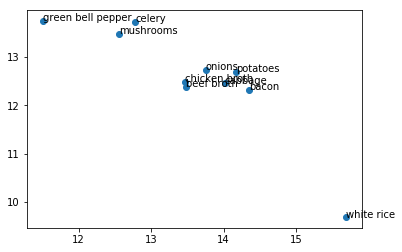

In [22]:
showTSNEGraphForWord(w2v_model, df_tsne, pos_words=['onion']) 

              x         y              ingredient
193   13.694805  6.738381                    mint
316   12.329931  6.842040           picante sauce
434   13.680683  6.720203                   limes
590   -7.008638 -0.968062  solid white tuna water
853  -11.527440  9.173142        colbyjack cheese
1029  12.425940 -4.426644       mexicanstyle corn
1215  13.993352  6.599642                    dill
1485  13.585083  7.425647         cilantro leaves
1501   2.761989 -5.689609            salad shrimp
1523   4.340453  7.279146   green enchilada sauce


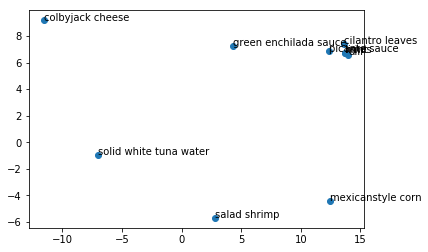

In [23]:
showTSNEGraphForWord(w2v_model, df_tsne, pos_words=['chicken', 'rice'], neg_words=['onions']) 

# POS Tagging

In [24]:
import re

sentence = "I want 2 blarhg @#$"
re.sub('[^a-zA-Z]', ' ', sentence)

'I want   blarhg    '

In [20]:
def extractVerbs(row):
    instructions = row['instructionSteps']
    tokens = []
    for inst in instructions:
        inst = re.sub('[^a-zA-Z]', ' ', inst.lower())
        tokens += inst.split()
    lstTags = nltk.pos_tag(tokens)
    verbs = []
    for item in lstTags:
        if item[1] == 'VB':
            verbs.append(item[0])
    return set(verbs)


In [ ]:
df_verbs = df.copy()
df_verbs['verbs'] = df_verbs.progress_apply(extractVerbs, axis=1)

In [26]:
print df_verbs['verbs'].sample(5)

7271                          {chill}
1559           {wilt, cook, continue}
124       {cover, let, stand, remove}
3733    {c, continue, reduce, add, f}
7300               {f, melt, crumble}
Name: verbs, dtype: object


In [21]:
def combineIngredientActions(row):
    return row['cleanedIngredients'] + list(row['verbs'])


In [ ]:
df_verbs['combined_action_ingredients'] = df_verbs.progress_apply(combineIngredientActions, axis=1)
print('Training a Word2vec model for ingredients + actions...')
action_ingredients_w2v_model = Word2Vec(df_verbs['combined_action_ingredients'].values, size=100, window=5, \
                                        min_count=5, workers=4)

In [28]:
action_ingredients_w2v_model.wv.most_similar(positive=['chop'])

[(u'absorb', 0.9983037710189819),
 (u'ladle', 0.9977494478225708),
 (u'quart', 0.9971503019332886),
 (u'drizzle', 0.997072696685791),
 (u'maintain', 0.996862530708313),
 (u'bowl', 0.9966187477111816),
 (u'flake', 0.9964179992675781),
 (u'smoke', 0.9963693022727966),
 (u'roast', 0.9963089227676392),
 (u'strain', 0.9961963891983032)]

In [29]:
X_2 = action_ingredients_w2v_model[action_ingredients_w2v_model.wv.vocab]

tsne_2 = TSNE(n_components=2)
X_tsne_2 = tsne.fit_transform(X_2)

vocab_2 = list(action_ingredients_w2v_model.wv.vocab)
df_tsne_2 = pd.concat([pd.DataFrame(X_tsne_2),
                pd.Series(vocab_2)],
               axis=1)
df_tsne_2.columns = ['x', 'y', 'ingredient']
df_tsne_2.sample(5)

,x,y,ingredient
1366,2.433124,6.493531,parmigianoreggiano cheese
531,-5.187760,-9.889359,skin
1563,-12.442057,-9.832002,super sugar
619,-8.335334,-0.053877,ancho chiles
508,-1.026629,-7.287316,seedless red grapes


              x          y            ingredient
248    4.708365 -13.208261  mexican blend cheese
314   10.638604   4.778596           feta cheese
473    4.968600   6.176991          leaves basil
649  -11.391812  17.478182                  pink
804  -10.078073   9.313967                  slow
868   -6.337617  18.087401                   pot
979    0.895229   7.115020        hamburger buns
1017 -11.359640  17.140160                 taste
1214   9.494820   4.762712               lettuce
1732  10.455065   4.588723                tomato


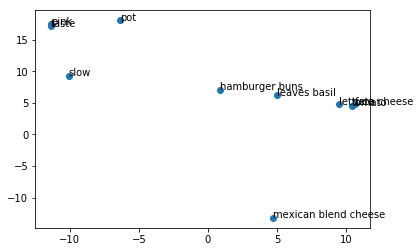

In [30]:
showTSNEGraphForWord(action_ingredients_w2v_model, df_tsne_2, pos_words=['chicken', 'rice'], neg_words=['onions']) 

# Final Dataset

In [31]:
# define the variables
EMBEDDING_SIZE = 50
MAX_LEN = 50

In [32]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_verbs['consolidated_category'])
print le.classes_

['african' 'east_asian' 'east_european' 'latin_american' 'middle_eastern'
 'north_american' 'north_european' 'south_asian' 'south_european'
 'southeast_asian']


In [39]:
df_verbs['features'] = df_verbs['combined_action_ingredients'].progress_map(lambda x : ','.join(x).encode('ascii'))
df_verbs['label'] = le.transform(df_verbs['consolidated_category'])


100%|██████████| 14442/14442 [00:00<00:00, 191231.60it/s]


In [40]:
features = df_verbs['features'].values
labels = df_verbs['label'].values

In [41]:
np.random.choice(features)

'white bread crusts,margarine,candy sprinkles,serve'

In [42]:
final_X = df_verbs['features'].values
final_Y = df_verbs['label'].values

X_train, X_test, y_train, y_test = train_test_split(final_X, final_Y, test_size=0.20)

In [50]:
cv = CountVectorizer(ngram_range=(1,2), stop_words='english', tokenizer=lambda x: x.split(','))
recipe_vocab_matrix = cv.fit_transform(X_train)
#cv.get_feature_names()
vocab_counts = zip(cv.get_feature_names(), np.asarray(recipe_vocab_matrix.sum(axis=0)).ravel())
df_vocab_counts = pd.DataFrame(vocab_counts, columns=['ingredient', 'count'])
df_vocab_counts.sample(15)

,ingredient,count
70801,water asparagus,2
631,allow onion,1
62336,spanish rice mix flour,1
47803,pepperoncini peppers,11
68097,turkey broth turkey filling,1
64966,t melt,1
585,allow catch,2
55315,rolled,1
7156,boiling water salt,2
42163,mussels debearded virgin olive oil,1


In [32]:
def print_metrics(true_y, predicted_y, target_names, y_score=None):
    """ Prints classification metrics
    Args:
        true_y: The ground truth target labels
        predicted_y: The predicted labels from the classifier
        y_score: If not None, this is vector of probability scores for positive class (used for roc_curve) (Optional)
    Returns:
        None
    """
    print classification_report(true_y, predicted_y, target_names=target_names)
    cm = confusion_matrix(true_y, predicted_y)
    print "Confusion matrix:"
    print cm
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print
    print "Confusion matrix(normalized):"
    print cm_normalized
    print
    
    print 'Overall accuracy: {}'.format(accuracy_score(true_y, predicted_y))
    print
    if y_score is not None:
        print "Area Under the ROC Curve: {}".format(roc_auc_score(true_y, y_score))
        print

# Simple Bigram Model with Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
def makePipeline():
    pipeline = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1,2), stop_words='english', tokenizer=lambda x: x.split(','))),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier(class_weight='balanced'))
    ])
    return pipeline
def trainModel(X, y):
    model = makePipeline()
    model.fit(X, y)
    return model

model = trainModel(X_train, y_train)
preds = model.predict(X_test)

In [48]:
print_metrics(y_test, preds, le.classes_)

                 precision    recall  f1-score   support

        african       0.25      0.10      0.14        20
     east_asian       0.58      0.57      0.57       125
  east_european       0.20      0.04      0.07        51
 latin_american       0.64      0.67      0.65       498
 middle_eastern       0.49      0.18      0.27       109
 north_american       0.49      0.73      0.59       932
 north_european       0.35      0.17      0.23       370
    south_asian       0.70      0.53      0.61       152
 south_european       0.64      0.59      0.61       511
southeast_asian       0.74      0.26      0.39       121

    avg / total       0.54      0.55      0.52      2889

Confusion matrix:
[[  2   0   0   3   0   7   0   5   3   0]
 [  0  71   0   6   1  42   0   2   0   3]
 [  0   0   2   2   0  34  11   0   2   0]
 [  1   2   2 332   1 117  11   2  26   4]
 [  1   0   0  11  20  47   4   4  22   0]
 [  0  20   1  94   7 677  49   4  79   1]
 [  1   6   2  18   4 244  63   3  27

# Embedding Layer

In [52]:
embedding_length = 200
top_words = 10000 
embedding_vecor_length = 200
tokenizer = Tokenizer(nb_words=top_words, split=',')
tokenizer.fit_on_texts(final_X)
sequences = tokenizer.texts_to_sequences(final_X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
final_X_embedded = pad_sequences(sequences, maxlen=embedding_length)
X_train, X_test, y_train, y_test = train_test_split(final_X_embedded, final_Y, test_size=0.20)

/home/apanza/anaconda2/lib/python2.7/site-packages/keras/preprocessing/text.py:139: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 9320 unique tokens.


# RNN model with LSTM

In [187]:
def processKerasRNNModel(X, y):    
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=embedding_length))
#     model.add(Dropout(0.5))
    model.add(LSTM(100)) #, return_sequences=True))
    model.add(Dropout(0.4))
#     model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(len(np.unique(labels)), activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
    print(model.summary())
    
    model.fit(X, y, epochs=5, batch_size=100)
    # Final evaluation of the model
    return model

In [188]:
rnn_cluster_model = processKerasRNNModel(X_train, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 1,081,410
Trainable params: 1,081,410
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
11553/11553 [==============================] - 74s - loss: 1.7924 - acc: 0.3490    
Epoch 2/5
11553/11553 [==============================] - 75s - loss: 1.2868 - acc: 0.5446    
Epoch 3/5
11553/11553 [==============================] - 69s - loss: 1.

In [191]:
preds = rnn_cluster_model.predict(X_test)

In [193]:
preds = [np.argmax(p) for p in preds]

In [194]:
print_metrics(y_test, preds, le.classes_)

                 precision    recall  f1-score   support

        african       0.00      0.00      0.00        28
     east_asian       0.54      0.76      0.63       135
  east_european       0.00      0.00      0.00        59
 latin_american       0.74      0.84      0.79       460
 middle_eastern       0.68      0.58      0.63       110
 north_american       0.70      0.63      0.66       946
 north_european       0.44      0.45      0.44       381
    south_asian       0.73      0.82      0.77       142
 south_european       0.69      0.80      0.74       534
southeast_asian       0.60      0.28      0.38        94

    avg / total       0.64      0.66      0.64      2889

Confusion matrix:
[[  0   3   0   0   3   2   5  13   2   0]
 [  0 103   0   1   0  17   5   2   2   5]
 [  0   1   0   1   1  15  40   0   1   0]
 [  0   0   0 386   0  45   8   8  11   2]
 [  0   3   0   5  64   9   7   3  19   0]
 [  0  21   0  92   4 599 127   4  94   5]
 [  0  11   0  18  10 102 173   4  62

/Users/chuqinghe/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# CNN Model

In [ ]:
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.utils import to_categorical


def trainKerasModel_conv(X,Y):
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=embedding_length))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(le.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
    print model.summary()
    model.fit(X, Y, epochs=10, batch_size=100)
    # Final evaluation of the model
    return model

conv_model = trainKerasModel_conv(X_train, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 128)          128128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               114816    
__________

In [47]:
preds = conv_model.predict(X_test)

In [48]:
preds = [np.argmax(p) for p in preds]

In [49]:
print_metrics(y_test, preds, le.classes_)

                 precision    recall  f1-score   support

        african       0.00      0.00      0.00        37
     east_asian       0.67      0.75      0.71       126
  east_european       0.38      0.07      0.11        46
 latin_american       0.79      0.82      0.80       530
 middle_eastern       0.55      0.54      0.55       103
 north_american       0.65      0.69      0.67       865
 north_european       0.47      0.45      0.46       386
    south_asian       0.74      0.78      0.76       156
 south_european       0.74      0.73      0.74       540
southeast_asian       0.52      0.58      0.55       100

    avg / total       0.65      0.67      0.66      2889

Confusion matrix:
[[  0   2   0   4   3   5   5  17   0   1]
 [  0  94   0   0   1  15   6   0   0  10]
 [  0   1   3   2   1  15  21   0   3   0]
 [  0   1   0 433   2  60  12   7   9   6]
 [  0   2   0   3  56   9  11   7  14   1]
 [  0  17   1  63   8 593  93   5  70  15]
 [  0  10   3  13   8 127 175   3  41

In [39]:
def saveKerasModel(modelName, model):
    model_json = model.to_json()
    with open(modelName, "w") as json_file:
        json_file.write(model_json)
def loadKerasModel(modelName):
    json_file = open(modelName, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model


In [50]:
saveKerasModel('conv_model_embed200_epoch5.json', conv_model)

In [51]:
!aws s3 cp conv_model_embed200_epoch5.json s3://RecipeVectors/


upload: ./conv_model_embed200_epoch5.json to s3://RecipeVectors/conv_model_embed200_epoch5.json


## Try Broader Categories

In [12]:
broader_cat_mapping_lines = """argentinian  latin_american
australian-and-new-zealander  european
austrian  european
bangladeshi  asian
belgian  european
brazilian  latin_american
canadian  north_american
chilean  latin_american
chinese  asian
colombian  latin_american
cuban  latin_american
czech  european
danish  european
dutch  european
east-african  african
egyptian  african
english  european
filipino  asian
finnish  european
french  european
german  european
greek  middle_eastern
hungarian  european
indian  asian
indonesian  asian
irish  european
israeli  middle_eastern
italian  european
jamaican  latin_american
japanese  asian
korean  asian
lebanese  middle_eastern
malaysian  asian
mexican  latin_american
moroccan  african
norwegian  european
pakistani  asian
persian  middle_eastern
peruvian  latin_american
polish  european
portuguese  european
puerto-rican  latin_american
russian  european
scottish  european
south-african  african
spanish  european
swedish  european
swiss  european
thai  asian
turkish  middle_eastern
us-recipes  north_american
vietnamese  asian
welsh  european"""

#print cat_mapping_lines
broader_cat_mapping_dict = {}
broader_cat_mapping_list = broader_cat_mapping_lines.split('\n')
#print cat_mapping_list

for mapping in broader_cat_mapping_list:
    #print line
    smaller_category, larger_category = mapping.split()
    broader_cat_mapping_dict[smaller_category] = larger_category
print broader_cat_mapping_dict

{'australian-and-new-zealander': 'european', 'portuguese': 'european', 'irish': 'european', 'mexican': 'latin_american', 'chinese': 'asian', 'czech': 'european', 'scottish': 'european', 'east-african': 'african', 'japanese': 'asian', 'moroccan': 'african', 'spanish': 'european', 'persian': 'middle_eastern', 'polish': 'european', 'austrian': 'european', 'swedish': 'european', 'israeli': 'middle_eastern', 'puerto-rican': 'latin_american', 'turkish': 'middle_eastern', 'south-african': 'african', 'bangladeshi': 'asian', 'german': 'european', 'peruvian': 'latin_american', 'indian': 'asian', 'dutch': 'european', 'korean': 'asian', 'pakistani': 'asian', 'colombian': 'latin_american', 'belgian': 'european', 'danish': 'european', 'indonesian': 'asian', 'hungarian': 'european', 'egyptian': 'african', 'welsh': 'european', 'brazilian': 'latin_american', 'us-recipes': 'north_american', 'french': 'european', 'lebanese': 'middle_eastern', 'norwegian': 'european', 'argentinian': 'latin_american', 'rus

In [13]:
def broader_consolidate_ethnic_categories(cat):
    return broader_cat_mapping_dict[cat]
df['broader_consolidated_category'] = df['ethnicCategory'].apply(broader_consolidate_ethnic_categories)

In [14]:
df.groupby('broader_consolidated_category').broader_consolidated_category.count()

broader_consolidated_category
african            140
asian             1885
european          4811
latin_american    2517
middle_eastern     555
north_american    4534
Name: broader_consolidated_category, dtype: int64

In [15]:
# not enough examples for african cuisine. just drop them
df = df[df.broader_consolidated_category != 'african']
df.groupby('broader_consolidated_category').broader_consolidated_category.count()

broader_consolidated_category
asian             1885
european          4811
latin_american    2517
middle_eastern     555
north_american    4534
Name: broader_consolidated_category, dtype: int64

In [17]:
from cleaning_util import extract_ingredients, translate_non_alphanumerics

tqdm.pandas()

In [18]:
df['cleanedIngredients']=df['ingredients'].progress_map(extract_ingredients)

100%|██████████| 14302/14302 [00:20<00:00, 692.55it/s]


In [22]:
df_verbs = df.copy()
df_verbs['verbs'] = df_verbs.progress_apply(extractVerbs, axis=1)

100%|██████████| 14302/14302 [01:56<00:00, 123.21it/s]


In [23]:
df_verbs['combined_action_ingredients'] = df_verbs.progress_apply(combineIngredientActions, axis=1)

100%|██████████| 14302/14302 [00:00<00:00, 27596.40it/s]


In [24]:
from gensim.models.word2vec import Word2Vec

In [25]:
print('Training a Word2vec model for ingredients + actions...')
action_ingredients_w2v_model = Word2Vec(df_verbs['combined_action_ingredients'].values, size=100, window=5, \
                                        min_count=5, workers=4)

Training a Word2vec model for ingredients + actions...


In [26]:
# define the variables
EMBEDDING_SIZE = 50
MAX_LEN = 50

In [27]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_verbs['broader_consolidated_category'])
print le.classes_

['asian' 'european' 'latin_american' 'middle_eastern' 'north_american']


In [29]:
df_verbs['features'] = df_verbs['combined_action_ingredients'].progress_map(lambda x : ','.join(x).encode('ascii'))
df_verbs['label'] = le.transform(df_verbs['broader_consolidated_category'])


100%|██████████| 14302/14302 [00:00<00:00, 194932.40it/s]


In [30]:
features = df_verbs['features'].values
labels = df_verbs['label'].values

In [72]:
features[3]

'beef ribs,green onion,carrots,garlic,ginger root,reducedsodium soy sauce,brown sugar,water cover,reduce,medium,cover'

In [31]:
final_X = df_verbs['features'].values
final_Y = df_verbs['label'].values

X_train, X_test, y_train, y_test = train_test_split(final_X, final_Y, test_size=0.20, stratify=final_Y)

In [33]:
embedding_length = 200
top_words = 10000 
embedding_vecor_length = 200
tokenizer = Tokenizer(nb_words=top_words, split=',')
tokenizer.fit_on_texts(final_X)
sequences = tokenizer.texts_to_sequences(final_X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
final_X_embedded = pad_sequences(sequences, maxlen=embedding_length)
X_train, X_test, y_train, y_test = train_test_split(final_X_embedded, final_Y, test_size=0.20, stratify=final_Y)

/home/apanza/anaconda2/lib/python2.7/site-packages/keras/preprocessing/text.py:139: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 9266 unique tokens.


In [35]:
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.utils import to_categorical

def trainKerasModel_conv(X,Y):
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=embedding_length))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(le.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
    print model.summary()
    model.fit(X, Y, epochs=6, batch_size=100)
    # Final evaluation of the model
    return model

conv_model = trainKerasModel_conv(X_train, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 200)          2000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 196, 128)          128128    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               114816    
__________

In [36]:
preds = conv_model.predict(X_test)
preds = [np.argmax(p) for p in preds]
print_metrics(y_test, preds, le.classes_)

                precision    recall  f1-score   support

         asian       0.79      0.76      0.77       377
      european       0.71      0.65      0.68       962
latin_american       0.79      0.65      0.72       504
middle_eastern       0.42      0.48      0.45       111
north_american       0.59      0.70      0.64       907

   avg / total       0.69      0.68      0.68      2861

Confusion matrix:
[[286  11  12  15  53]
 [ 24 627  30  34 247]
 [ 14  30 330   5 125]
 [ 10  35   2  53  11]
 [ 29 180  42  18 638]]

Confusion matrix(normalized):
[[ 0.75862069  0.02917772  0.03183024  0.0397878   0.14058355]
 [ 0.02494802  0.65176715  0.03118503  0.03534304  0.25675676]
 [ 0.02777778  0.05952381  0.6547619   0.00992063  0.24801587]
 [ 0.09009009  0.31531532  0.01801802  0.47747748  0.0990991 ]
 [ 0.03197354  0.19845645  0.0463065   0.01984564  0.70341786]]

Overall accuracy: 0.675987416987



In [41]:
saveKerasModel('cnn_consolidated_6epoch.json', conv_model)

In [43]:
import parsing_util
ingDict=parsing_util.Ingredients()
for idx, row in df_verbs.sample(3).iterrows():
    print row["url"]
    tokens = ingDict.parse(row["url"], row["ingredients"])
print tokens
ingDict.close()

http://allrecipes.com/recipe/237309/homemade-italian-red-sauce/
http://allrecipes.com/recipe/203097/southern-jambalaya/
http://allrecipes.com/recipe/100295/irish-champ/
[text {
  content: "2"
  begin_offset: -1
}
part_of_speech {
  tag: X
}
dependency_edge {
  head_token_index: 1
  label: NSUBJ
}
lemma: "2"
, text {
  content: "pounds"
  begin_offset: -1
}
part_of_speech {
  tag: VERB
  mood: INDICATIVE
  number: PLURAL
  person: THIRD
  tense: PRESENT
}
dependency_edge {
  head_token_index: 1
  label: ROOT
}
lemma: "pound"
, text {
  content: "potatoes"
  begin_offset: -1
}
part_of_speech {
  tag: NOUN
  number: SINGULAR
}
dependency_edge {
  head_token_index: 1
  label: DOBJ
}
lemma: "potato"
, text {
  content: ","
  begin_offset: -1
}
part_of_speech {
  tag: PUNCT
}
dependency_edge {
  head_token_index: 1
  label: P
}
lemma: ","
, text {
  content: "peeled"
  begin_offset: -1
}
part_of_speech {
  tag: VERB
  tense: PAST
}
dependency_edge {
  head_token_index: 1
  label: CONJ
}
lemm

In [44]:
ingDict=parsing_util.Ingredients()
for idx, row in df_verbs.sample(3).iterrows():
    print row["url"]
    tokens = ingDict.parse(row["url"], row["ingredients"])
    print tokens
ingDict.close()

http://allrecipes.com/recipe/216982/boiled-mustard-potatoes/
[text {
  content: "6"
  begin_offset: -1
}
part_of_speech {
  tag: NUM
}
dependency_edge {
  head_token_index: 1
  label: NUM
}
lemma: "6"
, text {
  content: "cups"
  begin_offset: -1
}
part_of_speech {
  tag: NOUN
  number: PLURAL
}
dependency_edge {
  head_token_index: 16
  label: NSUBJ
}
lemma: "cup"
, text {
  content: "water."
  begin_offset: -1
}
part_of_speech {
  tag: DET
}
dependency_edge {
  head_token_index: 1
  label: DEP
}
lemma: "water."
, text {
  content: "1"
  begin_offset: -1
}
part_of_speech {
  tag: NUM
}
dependency_edge {
  head_token_index: 5
  label: NUMBER
}
lemma: "1"
, text {
  content: "/"
  begin_offset: -1
}
part_of_speech {
  tag: X
}
dependency_edge {
  head_token_index: 5
  label: P
}
lemma: "/"
, text {
  content: "2"
  begin_offset: -1
}
part_of_speech {
  tag: NUM
}
dependency_edge {
  head_token_index: 6
  label: NUM
}
lemma: "2"
, text {
  content: "teaspoon"
  begin_offset: -1
}
part_of

## Try Binary Cuisine Categories: Not Asian, Asian

In [45]:
def binary_ethnic_categories(cat):
    if cat != 'asian':
        return 'not_asian'
    else:
        return 'asian'

In [47]:
df_verbs['binary_ethnic_category'] = df_verbs['broader_consolidated_category'].apply(binary_ethnic_categories)
df_verbs.groupby('binary_ethnic_category').binary_ethnic_category.count()

binary_ethnic_category
asian         1885
not_asian    12417
Name: binary_ethnic_category, dtype: int64

In [49]:
le.fit(df_verbs['binary_ethnic_category'])
print le.classes_

['asian' 'not_asian']


In [50]:
df_verbs['label'] = le.transform(df_verbs['binary_ethnic_category'])

In [52]:
labels = df_verbs['label'].values

final_Y = df_verbs['label'].values

X_train, X_test, y_train, y_test = train_test_split(final_X, final_Y, test_size=0.20, stratify=final_Y)

embedding_length = 200
top_words = 10000 
embedding_vecor_length = 200
tokenizer = Tokenizer(nb_words=top_words, split=',')
tokenizer.fit_on_texts(final_X)
sequences = tokenizer.texts_to_sequences(final_X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
final_X_embedded = pad_sequences(sequences, maxlen=embedding_length)
X_train, X_test, y_train, y_test = train_test_split(final_X_embedded, final_Y, test_size=0.20, stratify=final_Y)

Found 9266 unique tokens.


In [53]:
binary_conv_model = trainKerasModel_conv(X_train, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 200)          2000000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 196, 128)          128128    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               114816    
__________

In [54]:
# 3 epochs next time?
saveKerasModel('cnn_binary_6epoch.json', binary_conv_model)

In [55]:
preds = binary_conv_model.predict(X_test)
preds = [np.argmax(p) for p in preds]
print_metrics(y_test, preds, le.classes_)

             precision    recall  f1-score   support

      asian       0.84      0.72      0.77       377
  not_asian       0.96      0.98      0.97      2484

avg / total       0.94      0.94      0.94      2861

Confusion matrix:
[[ 270  107]
 [  53 2431]]

Confusion matrix(normalized):
[[ 0.71618037  0.28381963]
 [ 0.02133655  0.97866345]]

Overall accuracy: 0.944075498078



## Try Cleaner Ingredients, with Broader (5-class) Categories

In [59]:
!aws s3 cp s3://RecipeVectors/cleanerIngredients.pkl .

download: s3://RecipeVectors/cleanerIngredients.pkl to ./cleanerIngredients.pkl


In [61]:
with open('cleanerIngredients.pkl', 'rb') as f:
    cleaner_ingreds_dict = pickle.load(f)

In [62]:
print type(cleaner_ingreds_dict)
print len(cleaner_ingreds_dict)

<type 'collections.defaultdict'>
45245


In [66]:
cleaner_ingreds_dict.get('http://allrecipes.com/recipe/12726/grilled-halibut-i/')

{u'garnish',
 u'grapefruit juice',
 u'marjoram',
 u'olive oil',
 u'pepper',
 u'salt',
 u'steak'}

In [67]:
df_verbs.columns

Index([                           u'categories',
                                 u'cookingTime',
                                 u'description',
                              u'ethnicCategory',
                            u'fullCategoryTree',
                                 u'ingredients',
                            u'instructionSteps',
                                        u'name',
                                      u'rating',
                                 u'ratingCount',
                                         u'url',
       u'broader_consolidate_ethnic_categories',
               u'broader_consolidated_category',
                          u'cleanedIngredients',
                                       u'verbs',
                 u'combined_action_ingredients',
                                    u'features',
                                       u'label',
                      u'binary_ethnic_category'],
      dtype='object')

In [69]:
def lookup_cleaner_ingredients(row):
    cleaner_ingreds = cleaner_ingreds_dict.get(row['url'], row['cleanedIngredients'])
    # need to convert the set to a list???
    # if for some reason, the "cleaner" ingredients are not present in the dict, just use the "clean" ingredients
    return cleaner_ingreds

In [70]:
df_verbs['cleaner_ingredients'] = df_verbs.progress_apply(lookup_cleaner_ingredients, axis=1)

100%|██████████| 14302/14302 [00:00<00:00, 26877.85it/s]


In [71]:
df_verbs.sample(10)

,categories,cookingTime,description,ethnicCategory,fullCategoryTree,ingredients,instructionSteps,name,rating,ratingCount,url,broader_consolidate_ethnic_categories,broader_consolidated_category,cleanedIngredients,verbs,combined_action_ingredients,features,label,binary_ethnic_category,cleaner_ingredients
11690,"[Italian Recipes, Everyday Cooking, Recipes, A...",PT1H5M,NaN,italian,european/italian,"[3/4 cup cool water, divided, liquid rennet, 1...",[Combine 1/4 cup water and rennet in a small b...,Homemade Mozzarella Cheese,0.00,0,http://allrecipes.com/recipe/254478/homemade-m...,european,european,"[cool water, liquid rennet, citric acid, milk,...","{cut, f, stretch, knead, combine, stand, extra...","[cool water, liquid rennet, citric acid, milk,...","cool water,liquid rennet,citric acid,milk,salt...",1,not_asian,"{water, citric acid, salt, milk, rennet}"
5345,"[Yellow Cake From a Mix, Cake Mix Cakes, Birth...",PT2H30M,NaN,us-recipes,us-recipes,"[1 (18.25 ounce) package yellow cake mix, 1 (1...",[Preheat oven according to instructions on cak...,Bacon Cheeseburger Cake,4.83,22,http://allrecipes.com/recipe/81072/bacon-chees...,north_american,north_american,"[yellow cake mix, brownie mix, vanilla frostin...","{be, resemble, roll, flour, make, remove, soft...","[yellow cake mix, brownie mix, vanilla frostin...","yellow cake mix,brownie mix,vanilla frosting,y...",1,not_asian,"{vanilla frosting, red food coloring, green fr..."
7302,"[Shrimp Appetizers, Ceviche, Seafood Appetizer...",PT2H,NaN,mexican,latin-american/mexican,"[5 large lemons, juiced, 1 pound jumbo shrimp,...",[Place shrimp in a bowl (You may either coarse...,Mexican Ceviche,4.44,39,http://allrecipes.com/recipe/76469/mexican-cev...,latin_american,latin_american,"[lemons, shrimp, cilantro, tomato clam juice c...","{refrigerate, leave, desired, add, combine, ei...","[lemons, shrimp, cilantro, tomato clam juice c...","lemons,shrimp,cilantro,tomato clam juice cockt...",1,not_asian,"{tomato, cilantro, lemon, jalapeno, onion, rad..."
4698,"[Crawfish Recipes, Shrimp Recipes, Noodles, Sh...",PT1H15M,NaN,us-recipes,us-recipes,"[2 (16 ounce) packages extra-wide egg noodles,...",[Bring a large pot of generously salted water ...,Zesty Seafood Pasta,5.00,2,http://allrecipes.com/recipe/232250/zesty-seaf...,north_american,north_american,"[extrawide egg noodles, extravirgin olive oil,...","{set, shrimp}","[extrawide egg noodles, extravirgin olive oil,...","extrawide egg noodles,extravirgin olive oil,on...",1,not_asian,"{olive oil, dill, pepper, creole seasoning, th..."
8340,"[Pork Chili, Beef Chili, Chili, Soups, Stews a...",PT2H,NaN,us-recipes,us-recipes,"[1/2 pound bacon, 1 pound ground round, 1 poun...",[Place bacon in a large soup pot. Cook over me...,Habanero Hellfire Chili,4.71,232,http://allrecipes.com/recipe/25370/habanero-he...,north_american,north_american,"[bacon, pork, green bell pepper, yellow onion,...","{coat, reduce, remove, chop, add, continue}","[bacon, pork, green bell pepper, yellow onion,...","bacon,pork,green bell pepper,yellow onion,jala...",1,not_asian,"{tomato, pork, habanero pepper, red pepper fla..."
10756,"[Italian Recipes, Ravioli, Pasta by Shape, Eve...",PT1H15M,NaN,italian,european/italian,"[For the Filling:, 1 tablespoon olive oil, 1 (...",[Heat the olive oil in a large skillet over me...,"Spinach, Feta, and Pine Nut Ravioli Filling",4.62,22,http://allrecipes.com/recipe/213127/spinach-fe...,european,european,"[filling, olive oil, spinach, feta cheese, pin...","{cut, return, bring, remove, press, add, combi...","[filling, olive oil, spinach, feta cheese, pin...","filling,olive oil,spinach,feta cheese,pine nut...",1,not_asian,"{olive oil, water, pine nut, spinach, pastum, ..."
12904,"[English Recipes, Beef Sandwiches, Sandwiches,...",PT6H45M,NaN,english,european/uk-and-ireland/english,"[1 loaf hearty country bread, unsliced, 3 tabl...",[Cut a thick slice from the top of the loaf fo...,Shooter Sandwich,5.00,1,http://allrecipes.com/recipe/219468/shooter-sa...,e

In [77]:
print len(df_verbs['cleaner_ingredients'].values[3])
print type(df_verbs['cleaner_ingredients'].values[3])
print df_verbs['cleaner_ingredients'].values[3]
','.join(df_verbs['cleaner_ingredients'].values[3])

8
<type 'set'>
set(['water cover', u'short rib', u'ginger', u'soy sauce', u'carrot', u'garlic', u'brown sugar', u'green onion'])


u'water cover,short rib,ginger,soy sauce,carrot,garlic,brown sugar,green onion'

In [79]:
unidecode.unidecode(','.join(df_verbs['cleaner_ingredients'].values[3]))

'water cover,short rib,ginger,soy sauce,carrot,garlic,brown sugar,green onion'

In [81]:
le.fit(df_verbs['broader_consolidated_category'])
print le.classes_

df_verbs['flattened_cleaned_ingredients'] = df_verbs['cleaner_ingredients'].progress_map(lambda x : unidecode.unidecode(','.join(x)))
df_verbs['label'] = le.transform(df_verbs['broader_consolidated_category'])

final_X = df_verbs['flattened_cleaned_ingredients'].values
final_Y = df_verbs['label'].values

#X_train, X_test, y_train, y_test = train_test_split(final_X, final_Y, test_size=0.20, stratify=final_Y)


100%|██████████| 14302/14302 [00:00<00:00, 133431.80it/s]

['asian' 'european' 'latin_american' 'middle_eastern' 'north_american']


In [82]:
embedding_length = 200
top_words = 10000 
embedding_vecor_length = 200
tokenizer = Tokenizer(nb_words=top_words, split=',')
tokenizer.fit_on_texts(final_X)
sequences = tokenizer.texts_to_sequences(final_X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
final_X_embedded = pad_sequences(sequences, maxlen=embedding_length)
X_train, X_test, y_train, y_test = train_test_split(final_X_embedded, final_Y, test_size=0.20, stratify=final_Y)

Found 5595 unique tokens.


In [83]:
conv_model_cleaner_broad = trainKerasModel_conv(X_train, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 200)          2000000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 196, 128)          128128    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               114816    
__________

In [84]:
saveKerasModel('conv_model_cleaner_broad.json', conv_model_cleaner_broad)

In [86]:
preds = conv_model_cleaner_broad.predict(X_test)
preds = [np.argmax(p) for p in preds]
print_metrics(y_test, preds, le.classes_)

                precision    recall  f1-score   support

         asian       0.80      0.72      0.76       377
      european       0.68      0.61      0.64       962
latin_american       0.70      0.73      0.71       504
middle_eastern       0.50      0.44      0.47       111
north_american       0.57      0.65      0.61       907

   avg / total       0.66      0.65      0.65      2861

Confusion matrix:
[[272  16  23   6  60]
 [ 19 589  44  27 283]
 [  7  31 366   8  92]
 [ 11  32   5  49  14]
 [ 29 197  83   8 590]]

Confusion matrix(normalized):
[[ 0.72148541  0.04244032  0.06100796  0.01591512  0.15915119]
 [ 0.01975052  0.61226611  0.04573805  0.02806653  0.29417879]
 [ 0.01388889  0.06150794  0.72619048  0.01587302  0.18253968]
 [ 0.0990991   0.28828829  0.04504505  0.44144144  0.12612613]
 [ 0.03197354  0.21719956  0.09151047  0.00882029  0.65049614]]

Overall accuracy: 0.65221950367



## Cleaner Ingredients with Actions

In [87]:
# with open('parsedInstructions.pkl', 'rb') as f:
#     parsed_instructions_dict = pickle.load(f)

In [90]:
from parsing_util import Instructions

instrs = Instructions()
instrs.parse('http://allrecipes.com/recipe/12726/grilled-halibut-i/', cleaner_ingreds_dict.get('http://allrecipes.com/recipe/12726/grilled-halibut-i/'))

[text {
   content: "Mix"
   begin_offset: -1
 }
 part_of_speech {
   tag: VERB
   number: SINGULAR
 }
 dependency_edge {
   label: ROOT
 }
 lemma: "Mix", text {
   content: "together"
   begin_offset: -1
 }
 part_of_speech {
   tag: ADV
 }
 dependency_edge {
   label: ADVMOD
 }
 lemma: "together", text {
   content: "grapefruit"
   begin_offset: -1
 }
 part_of_speech {
   tag: NOUN
   number: SINGULAR
 }
 dependency_edge {
   head_token_index: 3
   label: NN
 }
 lemma: "grapefruit", text {
   content: "juice"
   begin_offset: -1
 }
 part_of_speech {
   tag: NOUN
   number: SINGULAR
 }
 dependency_edge {
   label: DOBJ
 }
 lemma: "juice", text {
   content: ","
   begin_offset: -1
 }
 part_of_speech {
   tag: PUNCT
 }
 dependency_edge {
   head_token_index: 3
   label: P
 }
 lemma: ",", text {
   content: "olive"
   begin_offset: -1
 }
 part_of_speech {
   tag: ADJ
 }
 dependency_edge {
   head_token_index: 6
   label: AMOD
 }
 lemma: "olive", text {
   content: "oil"
   begin_offset: 

In [ ]:
def combineCleanerIngredientActions(row):
    return row['cleanedIngredients'] + list(row['verbs'])
